# NLP - Bot Detection in Reddit Posts 
## Thomas Brewer - Boston

## Overview

In this project we are provided with a list of Reddit posts, with an open ended analysis.  I have chosen to use 
*Natural Language Processing* (NLP) to build a model that predicts whether or not a post was written by a Reddit bot : the `AutoModerator`.  For this I use only the actual text in the Reddit posts.  To preprocess the data I use standard NLP techniques such as removing *stopwords* and *stemming* to eventually create data frame of predictive features.  Once the preprocessing is done, I use a *RandomForestClassifier* to predict which category a post falls into (`AutoModerator` or not).

## Importing Necessary Libraries

In [111]:
# Import Libraries

# Standard / Basic Libraries
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# SciKit Learn Libraries
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Other
from importlib import reload # to reload libraries as I change them.
from wordcloud import WordCloud # to make a word cloud later
import re # Regular expressions
import warnings # To ignore warnings =p
import tools # My own library
reload(tools);
warnings.filterwarnings('ignore')



## Loading the Data

In [2]:
data = pd.read_csv('reddit_posts.csv')

In [4]:
# Load data and see the head to get a basic idea of what we're looking at
data = pd.read_csv('reddit_posts.csv')
data.head()

,adserver_click_url,adserver_imp_pixel,archived,author,author_flair_css_class,author_flair_text,contest_mode,created_utc,disable_comments,distinguished,...,spoiler,stickied,subreddit,subreddit_id,third_party_tracking,third_party_tracking_2,thumbnail,title,ups,url
0,NaN,NaN,False,johnnyawesome0,NaN,NaN,False,1480697304,NaN,NaN,...,False,False,techsupport,t5_2qioo,NaN,NaN,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...
1,NaN,NaN,False,Silverfin113,NaN,NaN,False,1480697424,NaN,NaN,...,False,False,learnprogramming,t5_2r7yd,NaN,NaN,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...
2,NaN,NaN,False,bookbooksbooks,NaN,NaN,False,1480697613,NaN,NaN,...,False,False,gamedev,t5_2qi0a,NaN,NaN,self,Seeking Tales of Development Woe (and Triumph)...,12.0,https://www.reddit.com/r/gamedev/comments/5g4a...
3,NaN,NaN,False,[deleted],NaN,NaN,False,1480697634,NaN,NaN,...,False,False,learnprogramming,t5_2r7yd,NaN,NaN,default,[Java] Finding smallest value in an array,0.0,https://www.reddit.com/r/learnprogramming/comm...
4,NaN,NaN,False,caffeine_potent,NaN,NaN,False,1480697748,NaN,NaN,...,False,False,learnpython,t5_2r8ot,NaN,NaN,self,currying functions using functools,6.0,https://www.reddit.com/r/learnpython/comments/...


## Cleaning / Preprocessing the Data
### Removing Null Values
First thing we notice about the data is that there are A LOT of null values.  To get an idea, we use the function in `tools.py` file, that shows any column with null values, and gives the percentage of nulls for that column.

In [5]:
# Check percentage of null values in dataset
tools.percent_null(data)

Column                	N_null	% null
adserver_click_url    	26688 	100.0
adserver_imp_pixel    	26688 	100.0
author_flair_css_class	26253 	98.37005395683454
author_flair_text     	26337 	98.68480215827338
disable_comments      	26688 	100.0
distinguished         	26603 	99.68150479616307
href_url              	26688 	100.0
imp_pixel             	26688 	100.0
link_flair_css_class  	22396 	83.91786570743405
link_flair_text       	22078 	82.72631894484412
media                 	26420 	98.99580335731414
mobile_ad_url         	26688 	100.0
original_link         	26688 	100.0
post_hint             	23175 	86.83678057553956
preview               	23175 	86.83678057553956
promoted              	26688 	100.0
promoted_by           	26688 	100.0
promoted_display_name 	26688 	100.0
promoted_url          	26688 	100.0
secure_media          	26420 	98.99580335731414
third_party_tracking  	26688 	100.0
third_party_tracking_2	26688 	100.0


Some columns are actually completely null, and a good amount of them have over 20,000 null values (which is a lot for only 26688 rows).  So we're going to drop any column with more than 20,000 null values.  We also drop the `url` column since it is mostly a repeat of the `subreddit` column.

In [6]:
# Drop columns with more than 20000 null values.
data.dropna(thresh=20000,axis=1, inplace=True)
data.drop('url', axis=1, inplace=True)

### `[deleted]` and `[removed]` Posts
Some posts are not Null values, but they have been removed or deleted.  These show up as strings `[deleted]` and `[removed]`.  Here are some examples:

In [19]:
# Display a [deleted] post
data[data.selftext=='[deleted]'].head(1)

,archived,author,contest_mode,created_utc,domain,downs,edited,gilded,hide_score,id,...,score,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,thumbnail,title,ups
3,False,[deleted],False,1480697634,self.learnprogramming,0.0,1480698462,0.0,False,5g4awr,...,0.0,{},[deleted],False,False,learnprogramming,t5_2r7yd,default,[Java] Finding smallest value in an array,0.0


In [18]:
# Display a [removed] post
data[data.selftext=='[removed]'].head(1)

,archived,author,contest_mode,created_utc,domain,downs,edited,gilded,hide_score,id,...,score,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,thumbnail,title,ups
8,False,Steakuddin,False,1480697900,self.linux,0.0,False,0.0,False,5g4btt,...,2.0,{},[removed],False,False,linux,t5_2qh1a,default,Requesting help with moving a file from local ...,2.0


Deleted and removed posts appear for both the `AutoModerator` and the human posts.  It is important to remove them since they are indistinguishable (based on text only).  Before we do that however, we take a look at how many there are exactly, and what percentage of the total number of rows they represent :

In [27]:
# Get total number of rows, and the number of deleted/removed posts
N_rows    = data.shape[0]
N_deleted = data[data.selftext=='[deleted]'].shape[0]
N_removed = data[data.selftext=='[removed]'].shape[0]

# Display numbers and percentage of deleted + removed rows
print('N rows          : ', N_rows)
print('N [deleted]     : ', N_deleted)
print('N [removed]     : ', N_removed)
print('Percent Missing : ', 100*(N_deleted + N_removed) / N_rows)

N rows          :  26688
N [deleted]     :  5269
N [removed]     :  3211
Percent Missing :  31.774580335731414


About 31% of our rows are missing.  This is a significant number, but again they add no value to what we are trying to predict, so we get rid of them here :

In [30]:
data = data[(data.selftext != '[deleted]') & (data.selftext != '[removed]')]

### Making the Target Columns 

Now that we've removed unnecessary rows, let's create our target feature : `is_moderator`.  This is a simple boolean column that takes 1 if the post is written by the `AutoModerator` 0 otherwise.  Note we are making a new DataFrame in case we need to extract information from the original one later on.

In [31]:
# Create copy of columns of interest into a new DataFrame
sub_data = data[['selftext', 'author']].copy()

# Create a new column : is_moderator 1 if author=='AutoModerator' else 0
sub_data['is_moderator'] = sub_data['author'].apply(lambda x: 1 if x=='AutoModerator' else 0)

# Delete 'author` column (we don't need it anymore)
sub_data.drop('author', axis=1, inplace=True)

### Sample Posts 
Just to get an idea of the differences between automated posts and human ones, we take a look at one of each.

In [33]:
# Print a Sample post from the AutoModerator
print('AutoModerator Post :')
print(sub_data[sub_data['is_moderator'] == 1]['selftext'][355])
print('\n')

# Print a sample post from the humans
print('Other Post:')
print(sub_data['selftext'][0])

AutoModerator Post :
##Greetings Good People of /r/Technology,

Welcome to the /r/Technology Tech Support / General Discussion Thread.

**All questions must be submitted as top comments** (direct replies to this post).

As always, we ask that you keep it civil, abide by the [rules of reddit](http://www.reddit.com/rules) and mind your [reddiquette](https://www.reddit.com/wiki/reddiquette).  Please hit the report button on any activity that you feel may be in violation of any of the guidelines listed above.

[Click here to review past iterations of these support discussions.](https://www.reddit.com/r/technology/search?q=author%3AAutomoderator&amp;sort=new&amp;restrict_sr=on)

cheers, /r/technology moderators.



Other Post:
I have a Sony surround sound system for a blu-ray player with the 4.2mm connectors. Is there a way I can play all my other devices through my speakers. What kind of connectors and amps do I need to get it to work


From this we see that there are some clear differences in style.  For example, the `AutoModerator` is generally polite, isn't asking questions, includes a lot of URLs, has well formated paragraphs/sentences, etc...  Judging from these differences, our model should work pretty well.

### Train Test Splitting
Before going any further, let's separate our data.  First into *predictors* (`X`) and target (`y`), then into training and testing sets.  For this we use Stratification to keep the same proportion of `AutoModerator` posts in each split.

** Important Note : ** Standard practice usually splits the train-test sets into 2/3 - 1/3 ratios respectively.  Because there are a lot of rows, for computational convenience we will be splitting the data 1/2 - 1/2.  This way there are less posts to build the model on, and things run a little faster. 

In [34]:
# Define X0, y0 predictors and target before any splitting or transformation is done
X0 = sub_data['selftext'].values.copy()
y0 = sub_data['is_moderator'].values.copy()

In [35]:
# Create StratifiedShuffleSplit Generator
# Note we are using test_size of 0.5 to minimize computation time in training the model.
sss = StratifiedShuffleSplit(test_size=0.5, random_state=42, n_splits=1)
sss_gen = sss.split(sub_data['selftext'], sub_data['is_moderator'])

# Use indices from generator to get train-test data
X_train, y_train = [], []
X_test, y_test = [], []
for i,j in sss_gen:
    X_train.extend(X0[i])
    y_train.extend(y0[i])
    X_test.extend(X0[j])
    y_test.extend(y0[j])
    
# Turn into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [36]:
# Check to make sure everything is okay :
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9104,) (9104,)
(9104,) (9104,)


### Baseline Accuracy
Althought this is a little bit out of place, before going any further we should define our **baseline accuracy**.  This is placed in the *Preprocessing* section so that we make sure it is defined before any changes have been made to the data.  We start by looking at how many `AutoModerator` posts there are in the testing set:

In [40]:
print('N People (test set)        : ', len(y_test) - sum(y_test))
print('N AutoModerator (test set) : ', sum(y_test))
print('test size                  : ', len(y_test))

N People (test set)        :  9062
N AutoModerator (test set) :  42
test size                  :  9104


In our testing set, there are 42 `AutoModerator` posts out of 9104 posts.  From this we define our **baseline accuracy** as the accuracy we would get if we predict No `AutoModerator` posts in the testing set.
<br><br>
$$ \text{baseline} = \frac{N_{\text{human}}}{N_{\text{total}}} = \frac{9062}{9104} \approx 0.9954$$
<br><br>
where $N_{\text{human}}$ is the number of posts (by people), and $N_{\text{total}}$ is the total number of posts (`AutoModerator` and people).  We save this number to compare to our future model's result.

In [41]:
# Save Baseline accuracy
baseline = (len(y_test) - sum(y_test)) / len(y_test)
print(baseline)

0.995386643234


As we can see, there are so little `AutoModerators` that without doing anything we would already get a 99.5% accuracy.  But, that would be a useless model, ideally we should be able to bring this number up to 100%.

### Preprocessing the Text
To make a good model, we are going to have to preprocess the text a little bit.  This may include taking out stopwords (common words that don't add meaning to the sentence such as "I", "am", etc), punctuation, stemming words (shortening things like "scientist, science => scien, scien).  For this I will be using the following function, which was in large part taken from the lecture.  An **important distinction** however is an added functionality to flag URLs.
<br>
<br>
Indeed, It seems like the `AutoModerator` includes URLs to various parts of reddit pretty often.  Because URLs include a lot of punctuation, and are all different, we decide to flag them.  This means that we are just taking note whether or not a piece of text is a URL or not.  We are not looking at where it links to.  URLs will be replaced with `thisisaurlletsflagit`.  For this I will be using a regular expression to find urls, which I did not write myself.  I found it on stackoverflow (https://stackoverflow.com/questions/6883049/regex-to-find-urls-in-string-in-python).  The reason for the odd text replacing the URLs is for one, because we want to minimize the chances of the replacement word to be in the text, and two because we don't care what the URLs are, we just want to know if there are any, and how many.
<br>
<br>
To recap the following function : 
- Flags URLs
- Turns all text to lower case (so that Dummy and dummy are considered the same word)
- Stems words (so that Scientist and Scientific portray the same idea)
- Removes Stop Words
- Removes spaces

In [43]:
def process_text(text):
    # Replace urls with a flag text
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    if (urls != None):
        for u in urls:
            # Note that a space was added before and after to make sure the url flag is a separate word
            text = text.replace(u, ' thisisaurlletsflagit ')

    # Get stop words, and instantiate stemmer object
    stop    = stopwords.words('english')
    stemmer = PorterStemmer()
    
    # Make all characters in text lower case
    text = text.lower()
    
    # Translations
    # Since we marked URLS in a way that doesn't use punctuation, we can safely take punctuation out of the 
    # equation.
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = text.translate(str.maketrans('', '', string.digits)) # remove numbers
    
    # Split text into all its different words, and process the words individually
    new_text = []
    for w in text.split():
        w = w.strip() # make sure there a no extra white spaces
        if w in stop:
            # Go to next iteration if w is a stop word
            continue
        
        # Get rid of any left over apostrophes
        w.replace("'", " ")
        
        # Stem words and append new word to a list
        w = stemmer.stem(w)
        new_text.append(w)
    
    # Return processed words as one long string
    return ' '.join(new_text)

** Note : ** We will not actually be running this function on our DataFrame because the NLP tools we will be using have a `preprocessor` parameter that we can assign to the function.

### Preprocessing - `CountVectorizer`
To transform text into useful features there are a number of options.  The first we explore is the `CountVectorizer`, from the `SciKitLearn` library.  This tool counts the occurances of each word in the text, and saves the results as a dictionary : `{word : word_count}`.  As an option it can take `min_df=0.5` for example which means that only words that appear in 50% of the documents (posts in our case) will be saved in the dictionary.  This is a way to weed out features that will not provide much information to our model, but slow things down considerably.  That being said, we are using this parameter to only keep words that appear in 5 % of the documents.

In [44]:
# Instantiate CountVectorizer object, only keep words that appear in 5% of the documents.
cv = CountVectorizer(preprocessor=process_text, min_df=0.05)
cv.fit(X_train, y_train)

# Transform the data
X_cv = cv.transform(X_train)

In [45]:
# Turn the transformed data into a DataFrame
X_cv = pd.DataFrame(X_cv.todense(), columns=cv.get_feature_names())

In [46]:
X_cv.head()

,abl,actual,advanc,ago,also,anoth,anyon,anyth,app,appreci,...,way,websit,week,well,window,without,wonder,work,would,year
0,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,1,0,0,4,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,2,0,1,4,0


### EDA - `CountVectorizer`
With the `CountVectorizer` we've turned our text into 199 different features.  With this we can perform a little EDA and take a look at which words appear most often in `AutoModerator` posts and human posts. 

In [48]:
# Top 10 used words used for posts by the AutoModerator
auto_top10 = X_cv[y_train==1].sum().sort_values(ascending=False)[:10]
print(auto_top10)

thisisaurlletsflagit    96
question                78
post                    60
use                     54
code                    46
solut                   46
pleas                   39
help                    27
ask                     20
make                    19
dtype: int64


In [49]:
# Top 10 used words used for posts not written by the AutoModerator
human_top10 = X_cv[y_train == 0].sum().sort_values(ascending=False)[:10]
print(human_top10)

use                     5983
im                      5857
tri                     5152
work                    4682
window                  4123
get                     4092
thisisaurlletsflagit    4076
like                    3660
would                   3656
ive                     3557
dtype: int64


Now, mostly for fun, and a more visual representation of how words appear in different posts.  Let's make a wordcloud.  A Word cloud is simply a an image of most common words in a text.  The size of a word's font is proportional to the number of times it appears in the text.  For this we have to concatenate all the text together.  The following code does exactly that :

In [112]:
# Define string variables to hold the entire text
all_text   = '' # ALL text
human_text = '' # Only text written by humans
bot_text   = '' # Only text written by the AutoModerator

# Loop through posts in the training set, and concatenate the text to the 
# corresponding variables
for i, t in enumerate(X_train):
    all_text += t
    all_text += ' '
    
    if (y_train[i] == 1):
        # AutoModerator Text
        bot_text += t
        bot_text += ' ' # add space so that ending/beginning words aren't glued together
    elif(y_train[i] == 0):
        # Human Text
        human_text += t
        human_text += ' '

With the text put into long strings, let's use that to make the word clouds!

In [113]:
# Make the different word cloud objects
cloud_all   = WordCloud().generate(all_text)
cloud_human = WordCloud().generate(human_text)
cloud_bot  = WordCloud().generate(bot_text)

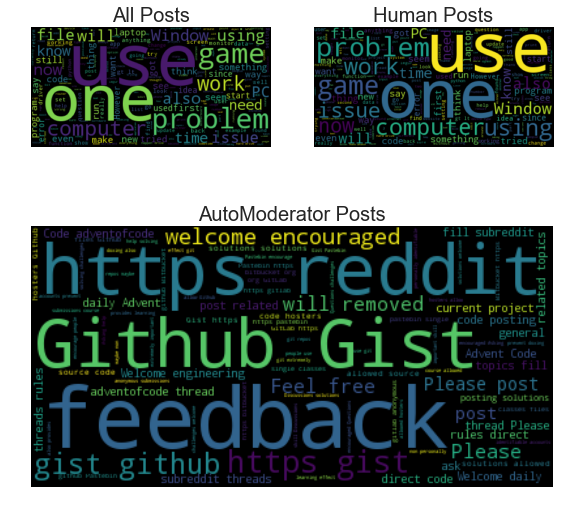

In [137]:
# Use cloud objects to generate the images
f = plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((2,2), (0,0))
ax1.imshow(cloud_all, interpolation='bilinear')
ax1.axis('off');
ax1.set_title('All Posts', fontsize=20)


ax2 = plt.subplot2grid((2,2), (0,1))
ax2.imshow(cloud_human, interpolation='bilinear')
ax2.axis('off');
ax2.set_title('Human Posts', fontsize=20)

ax3 = plt.subplot2grid((2,2), (1,0), colspan=2)
ax3.imshow(cloud_bot, interpolation='bilinear')
ax3.axis('off');
ax3.set_title('AutoModerator Posts', fontsize=20)
f.tight_layout()
plt.show()

Alright, this is very good.  Based on the word counts and clouds, we can see that the `AutoModerator` definitely has a different vocabulary than the humans.  Also, the URL flag we set up earlier appears in both sets, but the judging by the fact that `thisisaurlletsflagit` is the top word for the `AutoModerator`, it should be pretty helpful in classifying the two genres.
<br><br>
Now we could take a look at correlations between words, but honestly I'm not sure it's very useful.  The cloud already gives us an idea of what's correlated with `AutoModerator`, so let's jump right into the model from here!

### `RandomForestClassifier` with `CountVectorizer`
Without further ado, let's make our model!  For this we will using a `RandomForestClassifier`.  Let's start by running a `GridSearch` to find the best parameters for our model :

In [141]:
# GridSearch Set up for Our classification Model.
params = {
        'n_estimators' : [1, 5, 10, 20, 50, 100],
        'max_depth'     : [None, 5, 10, 20, 30]
}
M = RandomForestClassifier()
gs = GridSearchCV(M, param_grid=params, n_jobs=-1)

In [142]:
# Running the Grid search :
gs.fit(X_cv, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 5, 10, 20, 50, 100], 'max_depth': [None, 5, 10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Let's print out the best parameters for our `GridSearch`, and with those make our model object.

In [144]:
print(gs.best_params_)

{'max_depth': None, 'n_estimators': 50}


In [145]:
# Make our model :
M = RandomForestClassifier(max_depth=None, n_estimators=50, n_jobs=-1)
M.fit(X_cv, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

With our fitted model, let's take a look at how it fares with the training set.  For this we are using a function : `print_classification_results` from the `tools.py` module, which simply prints the score (accuracy), and difference with the baseline, and the confusion matrix:

In [149]:
# Print results
tools.print_classification_results(M, X_cv, y_train, baseline)

Score (Accuracy) :  1.0
% Difference with Baseline :  0.461335676626

Confusion Matrix :
[[9061    0]
 [   0   43]]


So the improvement from our baseline is about 0.46% better.  Which is actually quite good considering the small number of `AutoModerator` posts in the set.  Out of the 43 `AutoModerators`, we've already correctly classified all of them, with no False positives or False negatives.  This works quite well!
<br><br>
Let's see if we can get similar accuracy with our **test set**, note that we want to use the same object to transform the training and testing data.  This is also using the same function for preprocessing the text. 

In [150]:
# Transform predictors in test set.
X_cv_test = cv.transform(X_test)

In [151]:
tools.print_classification_results(M, X_cv_test, y_test, baseline)

Score (Accuracy) :  0.999890158172
% Difference with Baseline :  0.450351493849

Confusion Matrix :
[[9062    0]
 [   1   41]]


The model did not do as good a job with our testing set.  It is misclassifying 1 `AutoModerator`.  **How can we make this better?**

### Preprocessing with `TfidfVectorizer`
Since our model using `CountVectorizer` needed some improvement (albeit not much), let's take a look at what happens when we use a different preprocessing technique  `TfidVectorizer`. Straight from the documentation : *"Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency"*.  This means, with Tf-idf we are adding a weight to the word counts as follows :
<br><br>
$$
W = tf(t,D) - idf(t,d) = \frac{N_{\text{term}}}{N_{\text{docs}}} - \log\left(\frac{N_{\text{docs}}}{N_{\text{docs_with_t}}}\right)
$$
<br><br>
With this method, we are not only counting the words but taking into account how some words may occur more frequently in certain texts.  This helps to identify vocabulary that is representative of certains texts.
<br><br>
With this in mind, let's calculate those weights!

In [158]:
# Create Features with TFidVectorizer
tf = TfidfVectorizer(preprocessor=process_text, min_df=0.05)
tf.fit(X_train, y_train)
X_tf = tf.transform(X_train)

In [159]:
# Make DataFrame to get a view of what our data looks like
X_tf = pd.DataFrame(X_tf.todense(), columns=cv.get_feature_names())
X_tf.head()

,abl,actual,advanc,ago,also,anoth,anyon,anyth,app,appreci,...,way,websit,week,well,window,without,wonder,work,would,year
0,0.0,0.0,0.0,0.087237,0.0,0.0,0.073266,0.000000,0.000000,0.075039,...,0.000000,0.0,0.000000,0.082559,0.056194,0.000000,0.0,0.200583,0.053277,0.083046
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.162955,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.242929,0.000000,0.000000
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.344532,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.324921,0.0,0.000000,0.202381,0.000000
3,0.0,0.0,0.0,0.284070,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.303621,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.090155,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.204635,0.0,0.059985,0.254920,0.000000


### `RandomForestClassifier` with `TfidfVectorizer`

Now we'll be going through the same basic process as with the `CountVectorizer` so here it goes :

In [180]:
# GridSearch Set up for Our classification Model.
params = {
        'n_estimators' : [1, 5, 10, 20, 50, 100],
        'max_depth'     : [None, 5, 10, 20, 30]
}
M = RandomForestClassifier(n_jobs=-1)
gs = GridSearchCV(M, param_grid=params, n_jobs=-1)

In [181]:
# Running the Grid search :
gs.fit(X_tf, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 5, 10, 20, 50, 100], 'max_depth': [None, 5, 10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [182]:
# Print best parameters for gridsearch
print(gs.best_params_)

{'max_depth': None, 'n_estimators': 50}


In [183]:
# Train our model with the best parameters :
M = RandomForestClassifier(n_jobs=-1, max_depth=None, n_estimators=50)
M.fit(X_tf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

With our fitted model, let's take a look at the results using the training set :

In [184]:
tools.print_classification_results(M, X_tf, y_train, baseline)

Score (Accuracy) :  1.0
% Difference with Baseline :  0.461335676626

Confusion Matrix :
[[9061    0]
 [   0   43]]


So far so good, using `TfidfVectorizer` we are correctly classifying all of our posts in our training set.
<br><br>
**So how did we do with our testing set?**
<br> 

In [185]:
# Transform testing set using the TfidfVectorizer object:
X_tf_test = tf.transform(X_test)

In [186]:
tools.print_classification_results(M, X_tf_test, y_test, baseline)

Score (Accuracy) :  0.999890158172
% Difference with Baseline :  0.450351493849

Confusion Matrix :
[[9062    0]
 [   1   41]]


We are still misclassifying a test post, but I think we can still make improvements.  At this point our choices are : <br>
- Use a different model than `RandomForestClassifier`
- Change the way we preprocess our data
- Try to take into account a lower `min_df` when calling the Vectorizer.
<br><br>
Because I would rather test out the differences in accuracy using the same model, and I do not want to go back and change how I preprocess the data, I will start with the easiest path : *change the min_df* when calling the Vectorizer.  Because this will be computationally slow, I will not set it to zero right away.  Let's try using `min_df = 0.01`.  Also, since with more or less the same parameters the model seemed to work better with `TfidfVectorizer`, we will be sticking with that one from now on.

### Tweaking the `TfidfVectorizer`
As we just mentioned, still Using the `TfidVectorizer` we are seeing if we can minimally tweak the preprocessing and perhaps the model to catch that last `AutoModerator` post.

In [187]:
# Fit the TfidfVectorizer and transform the dataset
tf = TfidfVectorizer(preprocessor=process_text, min_df=0.01)
tf.fit(X_train, y_train)
X_tf = tf.transform(X_train)

Before doing anything let's see how many features we have (I'm scared): 

In [188]:
X_tf.shape

(9104, 884)

We've gone from about 200 features to 884.  That isn't so bad after all.  Let's make our model again!

In [189]:
# GridSearch Set up for Our classification Model.
params = {
        'n_estimators' : [10, 20, 50, 75, 100, 125],
        'max_depth'    : [None, 5, 10, 20, 40, 50]
}
M = RandomForestClassifier(n_jobs=-1)
gs = GridSearchCV(M, param_grid=params, n_jobs=-1)

In [190]:
gs.fit(X_tf, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 50, 75, 100, 125], 'max_depth': [None, 5, 10, 20, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [191]:
# See best parameters :
gs.best_params_

{'max_depth': None, 'n_estimators': 10}

In [192]:
M = RandomForestClassifier(n_jobs=-1, n_estimators=10, max_depth=None)
M.fit(X_tf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

** Let's see the Results on the Training Set **

In [193]:
tools.print_classification_results(M, X_tf, y_train, baseline)

Score (Accuracy) :  1.0
% Difference with Baseline :  0.461335676626

Confusion Matrix :
[[9061    0]
 [   0   43]]


So we're still getting everything on the training set.  That's pretty awesome.  Let's look at the **testing set!!!**

In [194]:
X_tf_test = tf.transform(X_test)

In [195]:
tools.print_classification_results(M, X_tf_test, y_test, baseline)

Score (Accuracy) :  0.999890158172
% Difference with Baseline :  0.450351493849

Confusion Matrix :
[[9062    0]
 [   1   41]]


Well... we are still not getting it! Let's try this **one last time** with an even lower `min_df`.

In [199]:
# Fit the TfidfVectorizer and transform the dataset
tf = TfidfVectorizer(preprocessor=process_text, min_df=0.005)
tf.fit(X_train, y_train)
X_tf = tf.transform(X_train)

In [200]:
X_tf.shape

(9104, 1358)

So here we went with a `min_df` of 0.005, meaning a word has to appear in 0.5% of the posts to get put into the dictionary.  With that we've jumped to 1358 features.  Let's see if that helps!

In [201]:
# GridSearch Set up for Our classification Model.
params = {
        'n_estimators' : [10, 20, 50, 75, 100, 125],
        'max_depth'    : [None, 5, 10, 20, 40, 50]
}
M = RandomForestClassifier(n_jobs=-1)
gs = GridSearchCV(M, param_grid=params, n_jobs=-1)

In [216]:
gs.fit(X_tf, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 50, 75, 100, 125], 'max_depth': [None, 5, 10, 20, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [217]:
gs.best_params_

{'max_depth': None, 'n_estimators': 50}

In [218]:
M = RandomForestClassifier(n_jobs=-1, n_estimators=50, max_depth=None)
M.fit(X_tf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [219]:
tools.print_classification_results(M, X_tf, y_train, baseline)

Score (Accuracy) :  1.0
% Difference with Baseline :  0.461335676626

Confusion Matrix :
[[9061    0]
 [   0   43]]


Again, we catch every `AutoModerator` in our training set.  Let's see for the testing:

In [220]:
X_tf_test = tf.transform(X_test)

In [221]:
tools.print_classification_results(M, X_tf_test, y_test, baseline)

Score (Accuracy) :  0.999890158172
% Difference with Baseline :  0.450351493849

Confusion Matrix :
[[9062    0]
 [   1   41]]


Making the `min_df` even smaller **did not** make a difference in our results.  I will not be testing any more variations of this model, but let's take a look at some samples to spot the differences.  

In [222]:
# First get out our predictions : 
y_pred = M.predict(X_tf_test)

In [228]:
# Sample Correctly Predicted AutoModerator
print("Falsely Predicted Text :")
print('')
print(X_test[(y_pred == 0) & (y_test == 1)][0])
print('')
print('Correctly Predicted Sample :')
print('')
print(X_test[(y_pred == 1) & y_test == 1][0])

Falsely Predicted Text :

Welcome to /r/engineering's bi-weekly advice mega-thread! Here, prospective engineers can ask questions about university major selection, career paths, and get tips on their resumes. If you're a student looking to ask professional engineers for advice, then look no more! Leave a comment here and other engineers will take a look and give you the feedback you're looking for. Engineers: please sort this thread by NEW to see questions that other people have not answered yet.  

Please check out /r/EngineeringStudents for more!


Correctly Predicted Sample :

Welcome to the daily [Advent Of Code](http://adventofcode.com) thread!

Please post all related topics *only* here and do not fill the subreddit with threads.

The rules are:
 
+ **No direct code posting of solutions** - solutions are only allowed on source code hosters, like: [Github Gist](https://gist.github.com), [Pastebin](https://pastebin.com) (only for single classes/files!), [Github](https://github.com)

So there are some clear style differences between the text that got left out and the sampe. No links, less + signs, etc... So perhaps there is nothing we can do except explicitly account for that type of post (which might be a bad idea).  

### Final Thoughts on the `AutoModerator` Classifier
Leaving the last post aside, our model did quite well in predicting which posts were from a bot and which posts were from humans.  We saw that the `TfidfVectorizer` does a better job at making distinguishing features for text.  This does make intuitive sense : If one post has a lot of `Hello Worlds` in it, but others have none,  `Hello World` would not be considered a characteristic feature of that type of posts.  It is better to see if the word(s) appear frequently over many posts.  We also saw that although the previous is true, it was better to have a lower cut off point for `min_df`.  This way we can potentially include more distinguishing features.  Another way to improve our model would be to include a higher percentage of posts in the training set.  This way we have better chances of catching unusual posts.  Judghing from the sample test, perhaps some sentiment analysis would have helped as well (the Bot seems much frendlier).  This way helful words would be classified as such.  But this is for another time.   